In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import tensorflow as tf

def create_model(input_shape, num_classes):
    kernel_size = 3
    pool_size = 2
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(tf.keras.layers.Conv1D(16,kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
    model.add(tf.keras.layers.Conv1D(32, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
    model.add(tf.keras.layers.Conv1D(64, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
    model.add(tf.keras.layers.Conv1D(128, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
'''

VIZ.

'''
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def plot_features(feature,feature_array,audio,id,sr=44100):

  #audio.shape = (44100,)
  #feature_array.shape = (44100,)

  time = np.linspace(0,len(audio)/sr,num=len(audio))
  f = plt.figure(figsize=(10, 3))
  plt.plot(time, audio)
  plt.title('Audio Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.savefig(f"/content/{id}_audio.png")
  plt.cla()
  plt.clf()
  plt.close('f')
  plt.close('all')

  plt.figure(figsize=(10, 3))

  if feature=="wavelet_transform":
    f = plt.plot(feature_array)
    plt.title('Wavelet Transform')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.savefig(f"/content/{id}_wavelet_transform.png")
    plt.cla()
    plt.clf()
    plt.close('f')
    plt.close('all')

  elif feature=="hilbert_envelope":
    f = plt.plot(time, feature_array)
    plt.title('Hilbert Envelope')
    plt.xlabel('Time (s)')
    plt.ylabel('Envelope Amplitude')
    plt.savefig(f"/content/{id}_hilbert_envelope.png")
    plt.cla()
    plt.clf()
    plt.close('f')
    plt.close('all')

  elif feature=="homomorphic_envelope":
    f = plt.plot(time, feature_array)
    plt.title('Homomorphic Envelope')
    plt.xlabel('Time (s)')
    plt.ylabel('Envelope Amplitude')
    plt.savefig(f"/content/{id}_homomorphic_envelope.png")
    plt.cla()
    plt.clf()
    plt.close('f')
    plt.close('all')


  plt.cla()
  plt.clf()
  plt.close('all')


In [ ]:
'''
FEATURES
'''

def compute_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    spectrogram = librosa.amplitude_to_db(S, ref=np.max)
    return spectrogram


def compute_wavelet_transform(audio, wavelet='db4', level=5):
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    coeffs_flat = np.concatenate([c.ravel
     () for c in coeffs])
    return coeffs_flat

def compute_hilbert_envelope(audio):
    analytic_signal = hilbert(audio)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def compute_homomorphic_envelope(audio, sr, low_freq=5, high_freq=40):
    # Logarithmic transformation
    # Adding a small value to avoid taking log of zero
    log_audio = np.log(audio + 1e-6)

    # Design a bandpass filter in the range [low_freq, high_freq]
    sos = butter(N=4, Wn=[low_freq/sr*2, high_freq/sr*2], btype='band', output='sos')

    # Apply the bandpass filter
    filtered_signal = sosfilt(sos, log_audio)

    # Exponential to get the envelope
    homomorphic_envelope = np.exp(filtered_signal) - 1

    return homomorphic_envelope

def create_feature_dictionary(y, sr):
    features = {}
    #features['spectrogram'] = compute_spectrogram(y, sr)
    features['wavelet_transform'] = compute_wavelet_transform(y)
    features['hilbert_envelope'] = compute_hilbert_envelope(y)
    features['homomorphic_envelope'] = compute_homomorphic_envelope(np.abs(y), sr)
    return features

In [ ]:
def create_chunks(y, sr=44100, length=5, label=None):
    chunk_size = sr * length
    num_chunks = len(y) // chunk_size

    chunks = []
    labels = []

    for i in range(num_chunks):
      start = i * chunk_size
      end = (i + 1) * chunk_size
      chunk = y[start:end]

      chunks.append(chunk)
      labels.append(label)

      if len(y) % chunk_size != 0:
        buffer_size = len(y) % chunk_size
        buffer = y[-buffer_size:]
        pad_length = chunk_size - buffer_size
        buffer = np.pad(buffer, (0, pad_length), mode='constant')

        chunks.append(buffer)
        labels.append(label)

    return chunks, labels

In [ ]:
import os
import zipfile
from google.colab import files

def save_features(id):
  drive_path = '/content/drive/My Drive/Plots'
  zip_filename = os.path.join(drive_path,f"plots{id}.zip")

  if not os.path.exists(drive_path):
        os.makedirs(drive_path)

  with zipfile.ZipFile(zip_filename, 'w') as myzip:
    for filename in os.listdir('.'):
      if filename.endswith('.png'):
        myzip.write(filename)
        os.remove(filename)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

labels_dir =  "/content/drive/MyDrive/FSDKaggle2018.meta/train_post_competition.csv"
data_dir =   "/content/drive/MyDrive/FSDKaggle2018.audio_train"

labels_df = pd.read_csv(labels_dir)

label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
labels_df = labels_df[labels_df['manually_verified'] == 1]

'''
target_classes = [2,5,6,8,13,19,21,29,30,37]
labels_df = labels_df[labels_df['label_encoded'].isin(target_classes)]
'''

labels_df = labels_df.groupby("label_encoded").head(50)
labels_df

,fname,label,manually_verified,freesound_id,license,label_encoded
1,001ca53d.wav,Saxophone,1,358827,Attribution,30
3,0033e230.wav,Glockenspiel,1,325017,Attribution,19
4,00353774.wav,Cello,1,195688,Attribution,6
6,003da8e5.wav,Knock,1,164564,Creative Commons 0,25
7,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0,21
...,...,...,...,...,...,...
7866,d59f621a.wav,Applause,1,241910,Attribution,1
7921,d6d11418.wav,Tearing,1,179016,Attribution,36
7945,d7857dfb.wav,Bus,1,338170,Creative Commons 0,5
7962,d7e5753e.wav,Bus,1,113350,Attribution,5


In [62]:
import librosa
from scipy.signal import hilbert, sosfilt, sosfreqz, butter
import pywt
#from sklearn.model_selection import KFold
import gc

sample_rate = 44100 #Hz
length = 3 #seconds


'''
MODEL PARAMETERS
'''
batch_size = 64
input_shape = ((sample_rate*length),4)
num_classes = 41
epochs = 50
learning_rate = 0.0001


'''
MODEL
'''
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = create_model(input_shape, num_classes)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

'''
TRAINING
'''

flag = True
count = 0
training_loss = []
training_accuracy = []
plot_id = 0

for epoch in range(epochs):
  print(f"Starting Epoch {epoch+1}/{epochs}")
  X_train = []
  Y_train = []

  for index,row in labels_df.iterrows():
    fname =  row['fname']
    label = row['label_encoded']

    try:
      audio_path = data_dir+"/"+fname
      y,sr = librosa.load(audio_path,sr=sample_rate)

      #Normalization
      y = y/np.max(np.abs(y))

      audio_chunks,labels = create_chunks(y=y,sr=sr,length=length,label=label)

      for audio,label in zip(audio_chunks,labels):
        if flag:
          count += 1
        feature_dict = create_feature_dictionary(audio, sr)

        audio_features = []
        audio_features.append(audio)

        for feature in feature_dict.keys():
          feature_array = feature_dict[feature]
          feature_array = feature_array[:audio.shape[0]]
          audio_features.append(feature_array)
          '''
          if flag and count<=5: #remove constraint on count to plot all features for all audio chunks
            plot_features(feature=feature,
                          feature_array=feature_array.reshape((feature_array.shape[1],)),
                          audio=audio.reshape((audio.shape[1],)),id=count,sr=sr)
          '''

        audio_features = np.stack(audio_features, axis=1)

        audio_features = audio_features.T

        X_train.append(audio_features)
        Y_train.append(label)


        if(len(X_train)==batch_size):
          Y_train = np.array(Y_train).reshape((batch_size,))
          X_train = np.array(X_train).reshape((batch_size, (sr*length), -1))

          history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=1,verbose=1)
          training_loss += history.history["loss"]
          training_accuracy += history.history["accuracy"]

          #if(training_accuracy[-1] > 0.1):
          #  print(label)

          save_features(plot_id)
          plot_id += 1

          del X_train
          del Y_train
          del feature_array
          del feature_dict
          del audio
          del label
          gc.collect()

          X_train = []
          Y_train = []

    except FileNotFoundError:
      print(audio_path+" file not found")
      continue
  flag = False

model.save("Conv1DWaveFeatures.h5")

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_97 (Conv1D)          (None, 132298, 16)        208       
                                                                 
 max_pooling1d_96 (MaxPooli  (None, 66149, 16)         0         
 ng1D)                                                           
                                                                 
 conv1d_98 (Conv1D)          (None, 66147, 32)         1568      
                                                                 
 max_pooling1d_97 (MaxPooli  (None, 33073, 32)         0         
 ng1D)                                                           
                                                                 
 conv1d_99 (Conv1D)          (None, 33071, 64)         6208      
                                                                 
 max_pooling1d_98 (MaxPooli  (None, 16535, 64)       

<ipython-input-62-e6ef81fa4c68>:52: UserWarning: PySoundFile failed. Trying audioread instead.
  y,sr = librosa.load(audio_path,sr=sample_rate)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/drive/MyDrive/FSDKaggle2018.audio_train/2cf471ed.wav file not found
1/1 [==============================] - 0s 371ms/step - loss: 3.6820 - accuracy: 0.0625
/content/drive/MyDrive/FSDKaggle2018.audio_train/36af0778.wav file not found
1/1 [==============================] - 0s 373ms/step - loss: 3.6953 - accuracy: 0.0000e+00
Starting Epoch 2/50
1/1 [==============================] - 0s 372ms/step - loss: 3.6493 - accuracy: 0.0156
/content/drive/MyDrive/FSDKaggle2018.audio_train/2cf471ed.wav file not found
1/1 [==============================] - 0s 373ms/step - loss: 3.6279 - accuracy: 0.0469
/content/drive/MyDrive/FSDKaggle2018.audio_train/36af0778.wav file not found
1/1 [==============================] - 0s 372ms/step - loss: 3.7077 - accuracy: 0.0156
Starting Epoch 3/50
1/1 [==============================] - 0s 372ms/step - loss: 3.6033 - accuracy: 0.0312
/content/drive/MyDrive/FSDKaggle2018.audio_train/2cf471ed.wav file not found
1/1 [==============================] - 0s 372ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


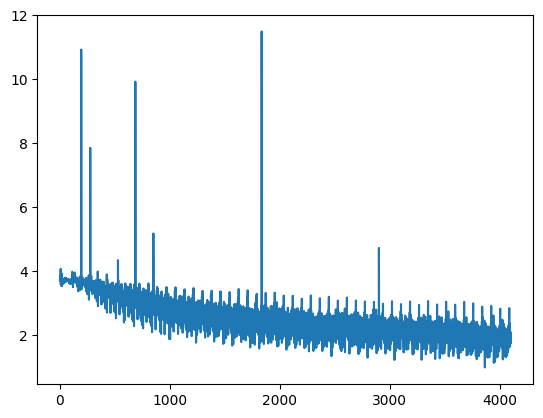

In [63]:
plt.plot(training_loss)
plt.savefig("training_loss.png")
plt.show()

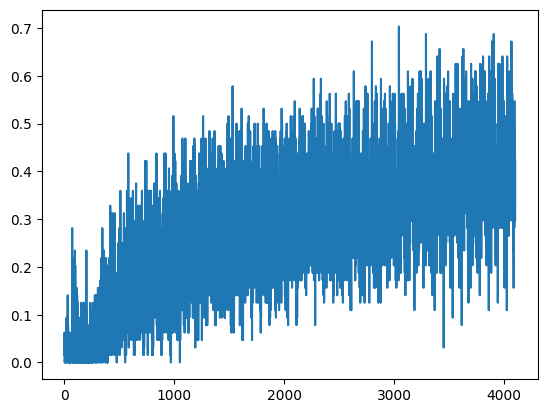

In [64]:
plt.plot(training_accuracy)
plt.savefig("training_accuracy.png")
plt.show()